In [2]:
import csv
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem


rose_data = pd.read_csv('rose_data.csv')  
# print(rose_data)

types = ["Acid SMILES", "Amine SMILES", "Catalyst1 SMILES", "Ligand1 SMILES", "Catalyst2 SMILES", "Base/Acid SMILES", "Reductant/Oxidant SMILES", "Additive SMILES", "Solvent1", "Solvent2"]
types2 = ["Acid", "Amine", "Catalyst 1", "Ligand 1", "Catalyst 2", "Base/Acid", "Reductant/Oxidant", "Additive", "Solvent1", "Solvent2"]

rose_mols = {}
rose_yields = {}

solvent_to_smiles = {
    "DMF": Chem.MolToSmiles(Chem.MolFromSmiles("O=CN(C)C")),
    "MeCN": Chem.MolToSmiles(Chem.MolFromSmiles("CC#N")),
    "Dioxane": Chem.MolToSmiles(Chem.MolFromSmiles("O1CCOCC1")),
    "Water": Chem.MolToSmiles(Chem.MolFromSmiles("O")),
    "1-methyl-2-pyrrolidinone": Chem.MolToSmiles(Chem.MolFromSmiles("O=C1N(C)CCC1")),
    "1,4-DIOXANE ANHYDROUS, 99.0%, ACROSEAL, QUADRANT CAP": Chem.MolToSmiles(Chem.MolFromSmiles("O1CCOCC1")),
    'TOLUENE, ANHYDROUS, 99.8%': Chem.MolToSmiles(Chem.MolFromSmiles("CC1=CC=CC=C1"))
}
rose_labels = {}
rose_names = {}
for t1,t2 in zip(types,types2):
    rose_mols[t2] = []
    rose_labels[t2] = []
    rose_names[t2] = []
    for k,yie,name in zip(rose_data[t1], rose_data["Output Value"], rose_data[t2]):
        if k == None or k =="nan" or k == np.nan or pd.isna(k):
            rose_mols[t2].append(np.zeros((1,2048))[0])
            if "none" not in rose_labels[t2]:
                rose_labels[t2].append("none")
                rose_names[t2].append("none")
            continue
        elif t2 == "Solvent1" or t2 == "Solvent2":
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(solvent_to_smiles[k]))
        else:
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(k))
        if sm not in rose_labels[t2]:
            rose_labels[t2].append(sm)
            rose_names[t2].append(name)
        if sm not in rose_yields:
            rose_yields[sm] = []
        rose_yields[sm].append(yie)
        fp = np.zeros((1,))
        # print(name)
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm), 4, nBits=2048), fp)
        rose_mols[t2].append(fp)
#             except:
#                 print(t2, sm)
#                 rose_mols[t2].append(np.zeros((1,)))
            
# for k in rose_mols:
#   print(k, len(rose_mols[k]))

In [19]:
rose_labels_one_hot = {}
for t1,t2 in zip(types,types2):
    rose_labels_one_hot[t2] = []
    for k,yie,name in zip(rose_data[t1], rose_data["Output Value"], rose_data[t2]):
        if k == None or k =="nan" or k == np.nan or pd.isna(k):
            rose_labels_one_hot[t2].append(rose_labels[t2].index("none"))
            continue
        elif t2 == "Solvent1" or t2 == "Solvent2":
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(solvent_to_smiles[k]))
        else:
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(k))
        rose_labels_one_hot[t2].append(rose_labels[t2].index(sm))

for k in rose_labels:
    print(k, len(rose_labels[k]), len(rose_labels_one_hot[k]))
    if k == "Solvent1" or k == "Solvent2":
        print(rose_labels[k])

Acid 23 1296
Amine 15 1296
Catalyst 1 13 1296
Ligand 1 28 1296
Catalyst 2 14 1296
Base/Acid 8 1296
Reductant/Oxidant 8 1296
Additive 5 1296
Solvent1 3 1296
['CN(C)C=O', 'CC#N', 'C1COCCO1']
Solvent2 3 1296
['none', 'O', 'CC#N']


In [23]:
rows = []
for i,k in rose_data.iterrows():
    # print(k["Solvent1"])
    if pd.isna(k["Solvent2"]):
        val = k["Solvent1"]
    else:
        val = k["Solvent1"]+"-"+k["Solvent2"]
    if val not in rows:
        rows.append(val)
print(len(rows))

5


In [4]:
rose_labels["Acid"].index("CC(C)(C)OC(=O)N1CCCC1C(=O)ON1C(=O)c2ccccc2C1=O")

1

In [5]:
n = 0
q = 0
n2 = 0
for k in rose_labels_one_hot["Acid"]:
    if k == 1:
        n2 = n2 + 1
    if "CC(C)(C)OC(=O)N1CCCC1C(=O)ON1C(=O)c2ccccc2C1=O" == rose_labels["Acid"][k]:
        n = n + 1
    if "CC(C)(C)OC(=O)N1CCCC1C(=O)O" == rose_labels["Acid"][k]:
        q = q + 1
print(n,q, n2)

456 336 456


In [6]:
for k in types2:
    print(len(rose_mols[k]))

1296
1296
1296
1296
1296
1296
1296
1296
1296
1296


In [12]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [13]:
total = np.zeros((1,))
yields = []
for k in rose_mols:
    total = total + rose_mols[k]
print(len(total))

for k in rose_data["Output Value"]:
    yields.append(k)


1296


In [7]:
from sklearn.manifold import TSNE


X_TSNE_RFP_ROSE = TSNE(n_components=2, n_jobs=-1, random_state=1).fit_transform(total)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


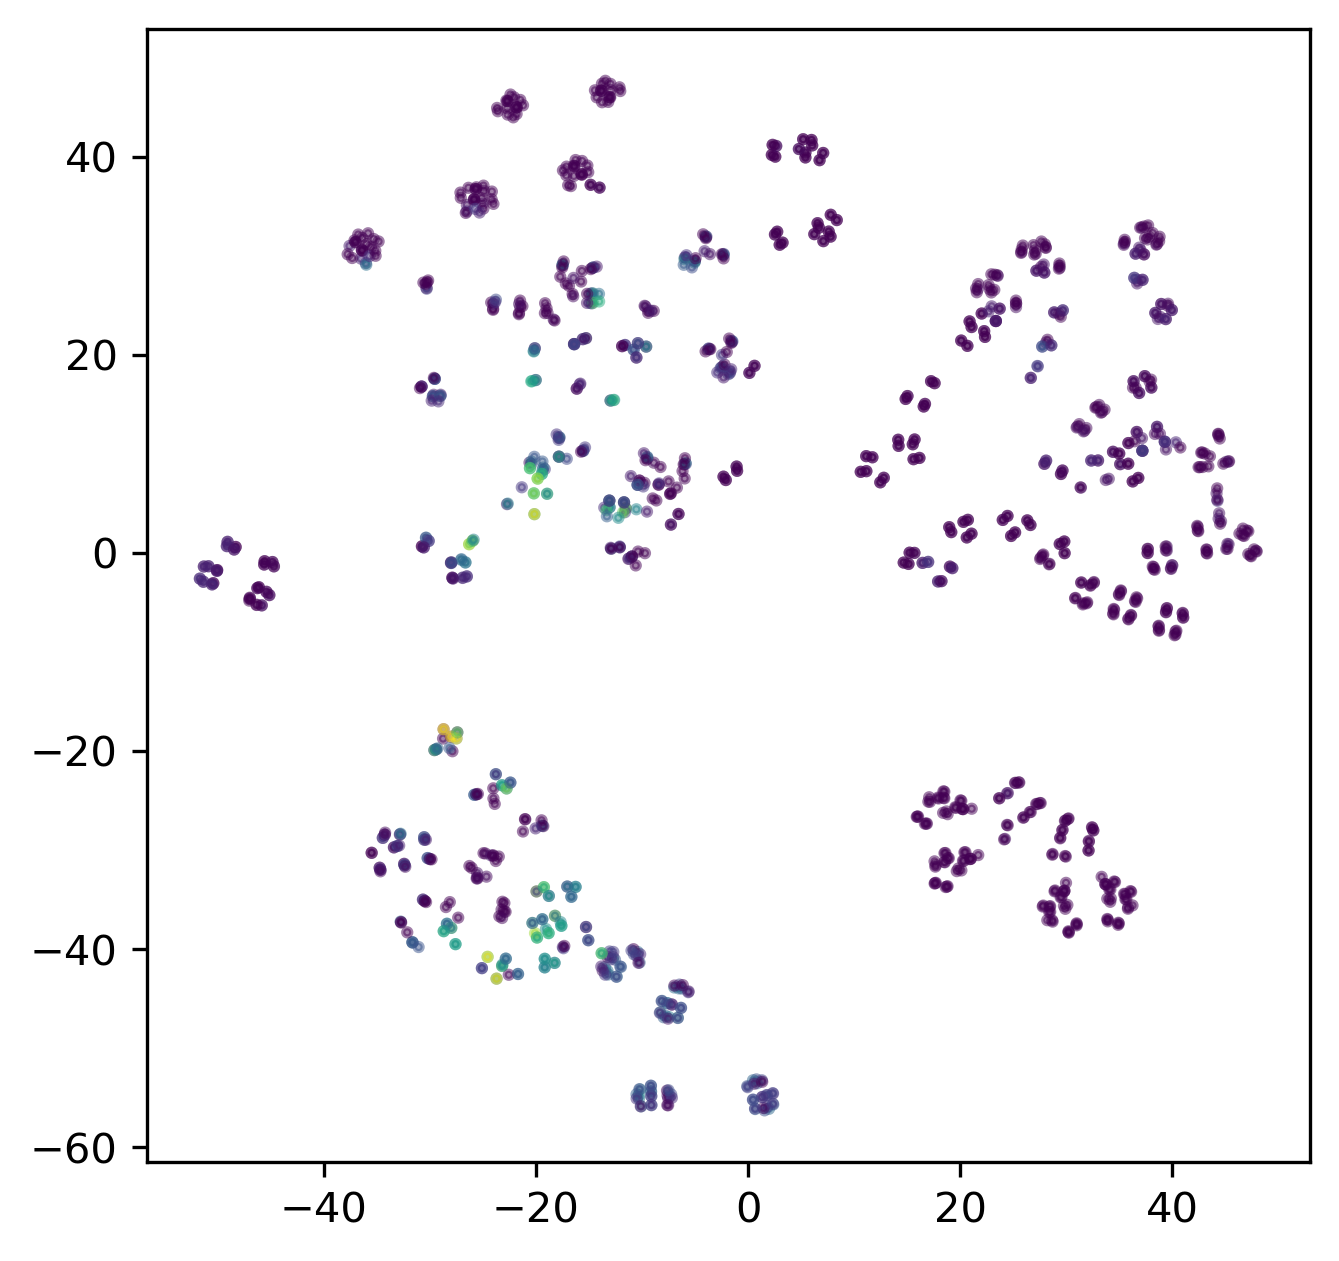

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5), dpi=300)

ax.scatter(X_TSNE_RFP_ROSE[:,0], X_TSNE_RFP_ROSE[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=15)

In [7]:
rxnfps_cat_3 = np.zeros((1,))
for k in rose_mols:
    if k == "Acid":
        j = []
        print(len(rose_mols[k]))
        for i in rose_mols[k]:
            j.append(i*3)
        rxnfps_cat_3 = rxnfps_cat_3 + j
    else:
        rxnfps_cat_3 = rxnfps_cat_3 + rose_mols[k]
    # print(rxnfps_cat_3)

1296


In [9]:
from sklearn.manifold import TSNE

X_TSNE_RFP_CAT_3 = TSNE(n_components=2, n_jobs=-1, random_state=1, perplexity=40).fit_transform(rxnfps_cat_3)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [10]:
tsne_split_by_type = {}
for i,k in enumerate(rose_labels_one_hot["Acid"]):
    if k not in tsne_split_by_type:
        tsne_split_by_type[k] = []
    tsne_split_by_type[k].append(X_TSNE_RFP_CAT_3[i,:])
labels = [k for k in tsne_split_by_type]

In [17]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

cmap = cm.get_cmap("inferno")

print(len(rose_names["Acid"]))
#rose_names["Acid"][k],rose_labels["Acid"][k],
for i,k in enumerate(labels):
    print(i+1, np.mean(rose_yields[rose_labels["Acid"][k]]), len(rose_yields[rose_labels["Acid"][k]]), matplotlib.colors.to_hex(cmap(norm(i))))

23


NameError: name 'norm' is not defined

In [21]:
matplotlib.colors.to_hex(cmap(norm(23)))

'#fcffa4'

23


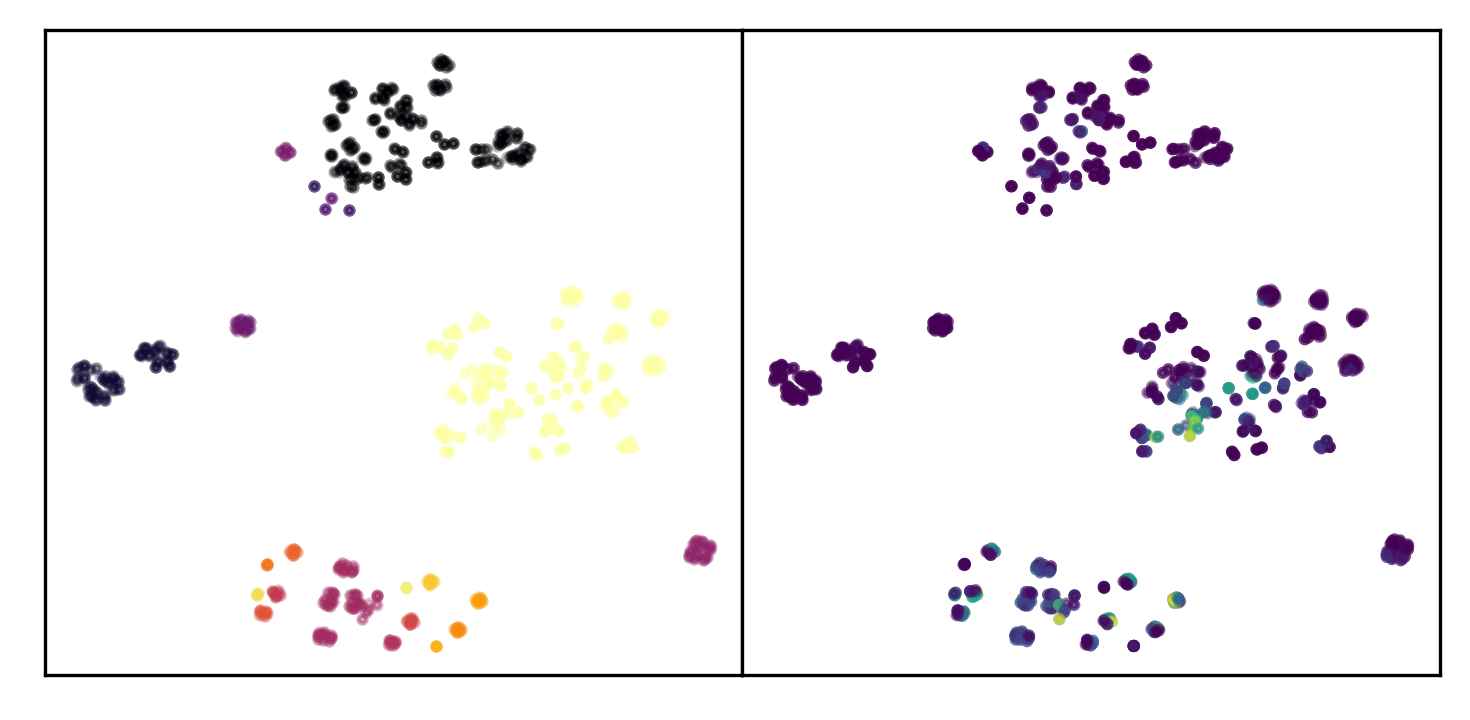

In [18]:
import matplotlib
import matplotlib.cm as cm
fig, ax = plt.subplots(1,2,figsize=(5,2.5), dpi=300)
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(tsne_split_by_type))
cmap = cm.get_cmap("inferno")
i = 0
print(len(tsne_split_by_type))
for k in tsne_split_by_type:
    arr = np.array(tsne_split_by_type[k])
    if i == 1:
        ax[0].scatter(arr[:,0], arr[:,1], cmap='inferno', color=cmap(norm(23)), alpha=.25, marker='.',s=15, label=labels[i])
    else:
        ax[0].scatter(arr[:,0], arr[:,1], cmap='inferno', color=cmap(norm(i)), alpha=.25, marker='.',s=15, label=labels[i])
    i = i + 1
ax[1].scatter(X_TSNE_RFP_CAT_3[:,0], X_TSNE_RFP_CAT_3[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=15)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[0].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figure3tsne.png', dpi=300, bbox_inches='tight')